#### About
Text similarity using BERT in PyTorch
Dataset - Quora Question pair - https://www.kaggle.com/competitions/quora-question-pairs/data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
#importing modules
import torch
! pip install transformers --quiet
from torch.utils.data import Dataset, DataLoader,TensorDataset, RandomSampler,SequentialSampler
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence
import transformers
from transformers import AutoTokenizer, BertForSequenceClassification
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 48.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 16.0 MB/s eta 0:00:00


In [4]:
os.chdir('/content/drive/MyDrive/Datasets/')

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
dataset_path = "train.csv"
#reading dataframe
df = pd.read_csv(dataset_path)
df

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...,...,...,...
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,404287,537928,537929,What is one coin?,What's this coin?,0
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0


In [7]:
#dropping null and duplicates
df = df.dropna()
df = df.drop_duplicates()
df

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...,...,...,...
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,404287,537928,537929,What is one coin?,What's this coin?,0
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


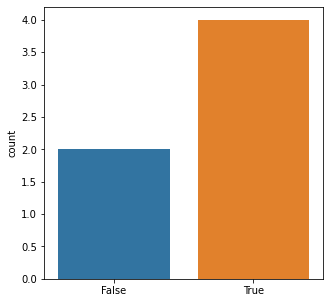

In [8]:
#visualising proportion of labels i.e similar and not similar
fig = plt.figure(figsize=(5,5))
sns.countplot(df.all(), x= 'is_duplicate')

plt.show()

In [9]:
#defining tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [10]:
#defining dataset
class QuestionSimilarityDataset(Dataset):
    def __init__(self,dataframe):
        self.dataframe = dataframe
        self.seg_ids, self.input_ids,self.attention_masks = [],[],[]
        question_1 = dataframe['question1'].values.tolist()
        question_2 = dataframe['question2'].values.tolist()
        self.labels = dataframe['is_duplicate'].values.tolist()
        #adding first sentence with CLS in beginning and SEP in end before appending next sentence
        #second sentence's end is being again appended with SEP in end
        for (q1,q2) in zip(question_1,question_2):
            q1 = '[CLS]' + q1 + '[SEP]'
            q1_tokens = tokenizer.tokenize(q1)
            #creating segmentation id - 0 for first sentence
            seg_ids = [0]*len(q1_tokens)
            #appending second sentence
            q2 = q2 + '[SEP]'
            q2_tokens = tokenizer.tokenize(q2)
            #seg id are 1 for second sentence
            seg_ids += [1]*len(q2_tokens)
            #assembling tokens
            q1_tokens+=q2_tokens
            #generating input_ids
            input_id = tokenizer.convert_tokens_to_ids(q1_tokens)
            self.input_ids.append(torch.tensor(input_id))
        #padding 
        self.padded_input_ids = pad_sequence(self.input_ids,batch_first=True, padding_value=0)
        #creating attention mask
        for seqs in self.padded_input_ids:
            self.attention_masks.append(torch.tensor([float(i>0) for i in seqs]))

    def __len__(self):
        return len(self.dataframe['question1'].values.tolist())
    
    def __getitem__(self,idx):
        item = {}
        item['input_ids'] = self.padded_input_ids[idx]
        item['attention_masks'] = self.attention_masks[idx]
        item['labels'] = self.labels[idx]
        return item
        

        

In [11]:
#splitting df into train,val
train_df,val_df = train_test_split(df,test_size=0.2,shuffle=True, random_state=42)

In [12]:
train_dataset = QuestionSimilarityDataset(train_df)
val_dataset = QuestionSimilarityDataset(val_df)

In [13]:
train_dataset.__getitem__(5)

{'input_ids': tensor([ 101, 2054, 4127, 1997, 6997, 2515, 1996, 8495, 2031, 3395, 3043, 7360,
         1029,  102, 2058, 2054, 4127, 1997, 6997, 2515, 1996, 8495, 2031, 3395,
         3043, 7360, 1029,  102,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0, 

In [14]:
#creating dataloaders
train_loader = DataLoader(train_dataset,batch_size=16, shuffle=True,pin_memory=True,num_workers=4)
val_loader = DataLoader(train_dataset,batch_size=16,shuffle=True,pin_memory=True,num_workers=4)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [15]:
for batch in train_loader:
    print(batch)
    break

{'input_ids': tensor([[ 101, 2029, 2003,  ...,    0,    0,    0],
        [ 101, 2064, 1045,  ...,    0,    0,    0],
        [ 101, 2040, 2024,  ...,    0,    0,    0],
        ...,
        [ 101, 2065, 2019,  ...,    0,    0,    0],
        [ 101, 2073, 2106,  ...,    0,    0,    0],
        [ 101, 2129, 2064,  ...,    0,    0,    0]]), 'attention_masks': tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.]]), 'labels': tensor([1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1])}


In [16]:
def accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [17]:
#instantiating the model and its hyperparams
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=2)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=0.1)

#advanced optimizer
"""param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
optimizer = AdamW(optimizer_grouped_parameters, lr=LEARNING_RATE, correct_bias=False)
"""

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
#training model
num_epochs =5
for epoch in range(num_epochs):
    model.train()
    train_loss=0.0
    num_steps=0
    for step,batch in enumerate(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_masks = batch['attention_masks'].to(device)
        labels = torch.tensor(batch['labels']).to(device)

        optimizer.zero_grad()

        outputs = model(input_ids,token_type_ids=None, attention_mask= attention_masks, labels = labels)
        loss = outputs[0]
        optimizer.step()

        train_loss+=loss.item()
        num_steps+=step
    print("Epoch - {}, Train Loss- {}".format(epoch, train_loss/num_steps))

    #validating
    model.eval()

    val_accuracy=0.0
    val_steps=0
    for step,batch in enumerate(val_loader):
        input_ids = batch['input_ids'].to(device)
        attention_masks = batch['attention_masks'].to(device)
        labels = torch.tensor(batch['labels']).to(device)
        
        with torch.no_grad():
            logits = model(input_ids,token_type_ids=None, attention_mask= attention_masks, labels = labels)
        
        logits = logits.detach().cpu().numpy()
        labels = labels.to('cpu').numpy()

        val_accuracy+= accuracy(logits,labels)
        val_steps+=step

    print("Val Accuracy - {}".format(val_accuracy))

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-24-533b5984b439>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(batch['labels']).to(device)


In [ ]:
torch.save(model.state_dict(),'Q_A.pt')